In [1]:
import unittest
import matplotlib
from neuronunit.allenapi.allen_data_driven import opt_setup, opt_setup_two, opt_exec
from neuronunit.allenapi.allen_data_driven import opt_to_model,wrap_setups
from neuronunit.allenapi.utils import dask_map_function

/home/rudolph/anaconda3/lib/python3.8/site-packages/cerberus/validator.py:1607: UserWarning: No validation schema is defined for the arguments of rule 'not_zero_obs_zscore'
  warn(


In [2]:
from neuronunit.optimization.optimization_management import check_bin_vm_soma
from neuronunit.optimization.model_parameters import MODEL_PARAMS, BPO_PARAMS, to_bpo_param
from neuronunit.optimization.optimization_management import dtc_to_rheo,inject_and_plot_model
import numpy as np
from neuronunit.optimization.data_transport_container import DataTC
import efel
from jithub.models import model_classes
import matplotlib.pyplot as plt
import quantities as qt
import os
from sciunit.scores import RelativeDifferenceScore,ZScore
import copy

In [3]:


class testOptimization(unittest.TestCase):
    def setUp(self):
        self = self
        self.ids = [ 324257146,
                325479788,
                476053392,
                623893177,
                623960880,
                482493761,
                471819401
               ]
        self.specimen_id = self.ids[1]
    def optimize_job(self,model_type,score_type=ZScore):

        target_num_spikes = 8
        dtc = DataTC()
        dtc.backend = model_type
        model = dtc.dtc_to_model()
        model.params = copy.copy(BPO_PARAMS[model_type])
        fixed_current = 122 *qt.pA
        if model_type is "ADEXP":
            NGEN = 100
            MU = 20
        else:
            NGEN = 100
            MU = 100
            
        mapping_funct = dask_map_function
        cell_evaluator,simple_cell,suite,target_current,spk_count = wrap_setups(
                  self.specimen_id,
                  model_type,
                  target_num_spikes,
                  template_model=copy.copy(model),
                  fixed_current=False,
                  cached=False,
                  score_type=score_type
        )
        del model

        final_pop, hall_of_fame, logs, hist = opt_exec(MU,NGEN,mapping_funct,cell_evaluator)
        opt,target = opt_to_model(hall_of_fame,cell_evaluator,suite, target_current, spk_count)
        best_ind = hall_of_fame[0]
        fitnesses = cell_evaluator.evaluate_with_lists(best_ind)
        target.vm_soma = suite.traces['vm15']
        check_bin_vm_soma(target,opt)
        
        return np.sum(fitnesses)
    def test_opt_relative_diff(self):
        model_type = "ADEXP"
        sum_fit = self.optimize_job(model_type,score_type=RelativeDifferenceScore)
        print('met fitness goals')
        #assert sum_fit<9.0
    def test_opt_ZScore(self):
        model_type = "ADEXP"
        sum_fit = self.optimize_job(model_type,score_type=ZScore)
        print('met fitness goals')
        #assert sum_fit<0.7

    def test_opt_relative_diff_izhi(self):
        model_type = "IZHI"
        self.optimize_job(model_type,score_type=RelativeDifferenceScore)

    def test_opt_ZScore_izhi(self):
        model_type = "IZHI"
        self.optimize_job(model_type,score_type=ZScore)


In [4]:
tt = testOptimization()
tt.setUp()


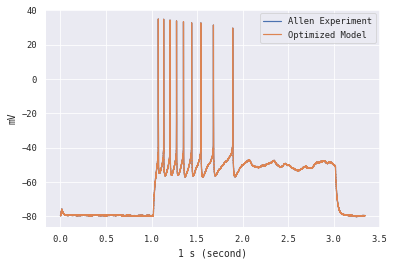

IzhiModel IZHI
IzhiModel IZHI
[<bluepyopt.parameters.Parameter object at 0x7f8043671310>, <bluepyopt.parameters.Parameter object at 0x7f8043671370>, <bluepyopt.parameters.Parameter object at 0x7f80436713d0>, <bluepyopt.parameters.Parameter object at 0x7f8043671430>, <bluepyopt.parameters.Parameter object at 0x7f8043671490>, <bluepyopt.parameters.Parameter object at 0x7f80436714f0>, <bluepyopt.parameters.Parameter object at 0x7f8043671550>, <bluepyopt.parameters.Parameter object at 0x7f80436715b0>, <bluepyopt.parameters.Parameter object at 0x7f8043671610>, <bluepyopt.parameters.Parameter object at 0x7f8043671670>]


2021-01-18 12:55:34.557 INFO    __main__: gen	nevals	avg    	std    	min    	max  
1  	100   	6011.28	9628.12	31.6277	22000


2021-01-18 12:57:07.017 INFO    __main__: 2  	72    	6338.02	9747.78	31.6277	22000
2021-01-18 12:57:49.045 INFO    __main__: 3  	68    	826.618	3844.25	31.1577	22000
2021-01-18 12:58:40.423 INFO    __main__: 4  	71    	1882.19	5583.68	31.1577	22000
2021-01-18 12:59:24.833 INFO    __main__: 5  	62    	906.262	3956.82	13.2672	22000
2021-01-18 12:59:56.213 INFO    __main__: 6  	52    	464.681	2791.35	13.2672	22000
2021-01-18 13:00:48.109 INFO    __main__: 7  	61    	1461.25	5231.66	13.2672	22000
2021-01-18 13:01:26.890 INFO    __main__: 8  	66    	212.378	1950.2 	13.2672	22000
2021-01-18 13:02:10.393 INFO    __main__: 9  	63    	678.773	3655.59	13.2672	22000
2021-01-18 13:02:54.144 INFO    __main__: 10 	68    	49.336 	141.305	13.2672	1036.06
2021-01-18 13:03:48.055 INFO    __main__: 11 	64    	1261.39	4886.8 	9.69307	22000  
2021-01-18 13:04:32.616 INFO    __main__: 12 	68    	205.71 	1951.64	8.18122	22000  
2021-01-18 13:05:16.987 INFO    __main__: 13 	66    	153.407	1508.5 	7.65869	1701

2021-01-18 14:30:39.997 INFO    __main__: 99 	62    	11.1948	5.03033	5.12873	35.336 
2021-01-18 14:31:28.115 INFO    __main__: 100	68    	186.757	1951.04	5.12873	22000  
2021-01-18 14:31:28.118 INFO    __main__: Run stopped because of stopping criteria: Max ngen


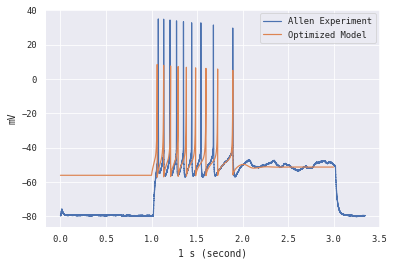

In [5]:
tt.test_opt_relative_diff_izhi()

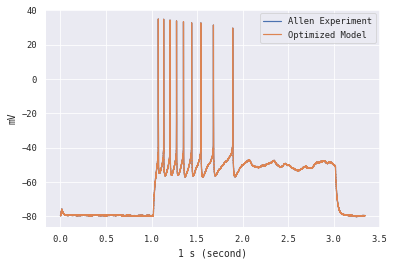

IzhiModel IZHI
IzhiModel IZHI
[<bluepyopt.parameters.Parameter object at 0x7f8043671310>, <bluepyopt.parameters.Parameter object at 0x7f8043671370>, <bluepyopt.parameters.Parameter object at 0x7f80436713d0>, <bluepyopt.parameters.Parameter object at 0x7f8043671430>, <bluepyopt.parameters.Parameter object at 0x7f8043671490>, <bluepyopt.parameters.Parameter object at 0x7f80436714f0>, <bluepyopt.parameters.Parameter object at 0x7f8043671550>, <bluepyopt.parameters.Parameter object at 0x7f80436715b0>, <bluepyopt.parameters.Parameter object at 0x7f8043671610>, <bluepyopt.parameters.Parameter object at 0x7f8043671670>]


2021-01-18 14:33:14.765 INFO    __main__: gen	nevals	avg    	std    	min    	max  
1  	100   	7002.21	9141.09	12.6378	22000


2021-01-18 14:34:40.136 INFO    __main__: 2  	72    	7251.13	9270.58	12.6378	22000
2021-01-18 14:35:15.905 INFO    __main__: 3  	72    	896.45 	3267.05	12.6378	22000
2021-01-18 14:36:08.222 INFO    __main__: 4  	67    	1926.02	5554.26	12.252 	22000


In [ ]:

tt.test_opt_ZScore_izhi()

# Z score works

In [ ]:

tt.test_opt_ZScore()


# Relative DIfference Also Works Now

In [ ]:


tt.test_opt_relative_diff()